In [2]:
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Combined_data.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [4]:
#standardize data: (x-mean(x))/std
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

numeric_columns=[c for c in df.columns if is_numeric_dtype(df[c])]
df=df[numeric_columns].dropna()
df=df[df.columns.difference(['Adult_ob','Adult_db',
                             'Low_Access_low_income','Low_Access_Seniors',
                             'Low_Access_Child', 'Very_low_insecurity'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3098 entries, 1001 to 56045
Data columns (total 25 columns):
<18                                  3098 non-null float64
>=65                                 3098 non-null float64
American Indian or Alaska Native     3098 non-null float64
Asian                                3098 non-null float64
Assistance                           3098 non-null float64
Black                                3098 non-null float64
Convenience                          3098 non-null float64
Farm                                 3098 non-null float64
Fast_food                            3098 non-null float64
Full_service                         3098 non-null float64
Grocery                              3098 non-null float64
Hawaiian or Pacific Islander         3098 non-null float64
Hispanic                             3098 non-null float64
Low_Access_Overall                   3098 non-null float64
Low_insecurity                       3098 non-null float64
Pove

In [6]:
normed_data=preprocessing.scale(df)
normed_df=pd.DataFrame(normed_data, index=df.index, columns=df.columns)

In [7]:
#PCA analysis using the standardized data
## compute the covariance matrix
corr=normed_df[normed_df.columns.difference(['Low_insecurity','level_diabetes','level_obesity','level_phy'])].corr()

In [8]:
evals, evecs = np.linalg.eigh(corr)

In [9]:
df_eigh=pd.DataFrame()
df_eigh['evalue']=evals
for i in range(len(evals)):
    df_eigh['evec_'+str(i+1)]=evecs[i,:]
df_eigh.index=corr.index

In [10]:
df_eigh=df_eigh.sort_values(by='evalue', ascending=False)
df_eigh['exp_var']=df_eigh['evalue']/df_eigh['evalue'].sum()
df_eigh['cum_exp_var']=np.cumsum(df_eigh['exp_var'])

In [11]:
df_eigh['cum_exp_var']

prevalence of physical inactivity    0.179744
prevalence of obesity                0.317538
prevalence of diabetes               0.415354
White                                0.491658
WIC_store                            0.547693
Supercenter                          0.598407
Specialized                          0.642429
SNAP_store                           0.683693
Recreation_facility                  0.720718
Poverty_rate                         0.754202
Low_Access_Overall                   0.787003
Hispanic                             0.818444
Hawaiian or Pacific Islander         0.846266
Grocery                              0.872699
Full_service                         0.896724
Fast_food                            0.916088
Farm                                 0.932963
Convenience                          0.948691
Black                                0.962152
Assistance                           0.974094
Asian                                0.984936
American Indian or Alaska Native  

explained variance exceeds 95% at variable 'Convenience', where we keep that variables from top until 'Convenience', so the dimentions decrease from 24 to 19

In [12]:
#PCA 

In [13]:
#PCA using Sklearn 
from sklearn.decomposition import PCA

explained_var=list()
for d in range(1,len(normed_df.columns)):
    pca = PCA(n_components=d)
    pca.fit(normed_df)
    explained_var.append(sum(pca.explained_variance_ratio_))

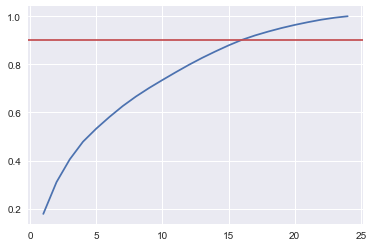

In [14]:
plt.plot(range(1,len(normed_df.columns)), explained_var)
plt.axhline(y=0.9, color='r')
plt.show()

In [15]:
#90% of variance can be explained by 16 components out of total 24 variables
pca = PCA(n_components=16)
pca.fit(normed_df)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
data_transformed=pca.transform(normed_df)
df_transformed=pd.DataFrame(data_transformed, index=normed_df.index)

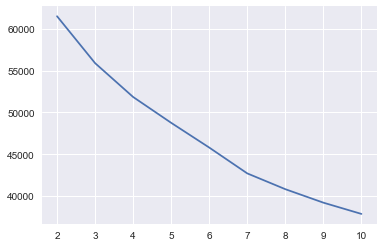

In [18]:
from sklearn.cluster import KMeans

SSE=list()
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data_transformed)
    SSE.append(kmeans.inertia_)
plt.plot(range(2,11), SSE)
plt.show()

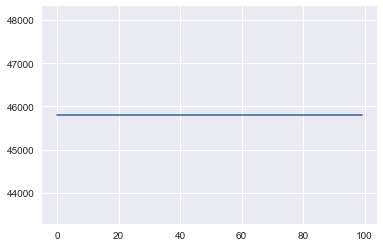

In [21]:
from sklearn.cluster import KMeans

SSE=list()
for n in range(100):
    kmeans = KMeans(n_clusters=6, random_state=40).fit(data_transformed)
    SSE.append(kmeans.inertia_)
plt.plot(range(100), SSE)
plt.show()

In [23]:
kmeans.labels_

array([1, 3, 5, ..., 3, 3, 4])

In [29]:
df['group']=kmeans.labels_

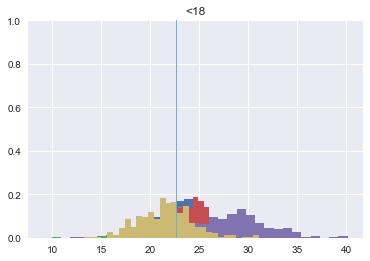

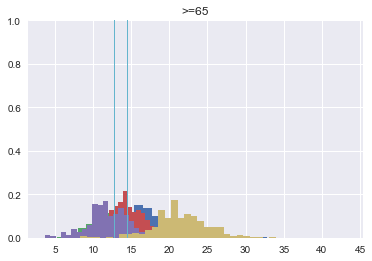

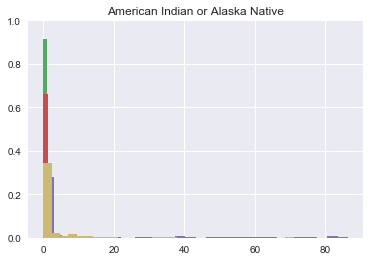

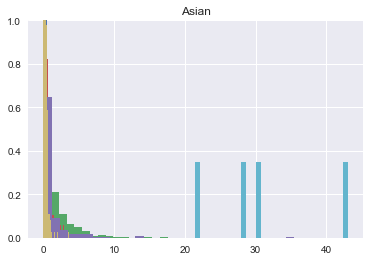

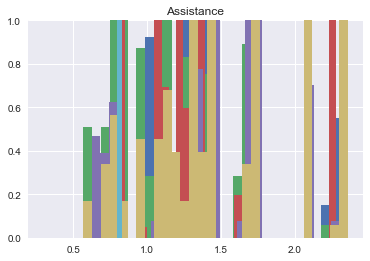

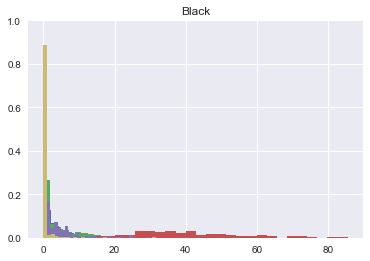

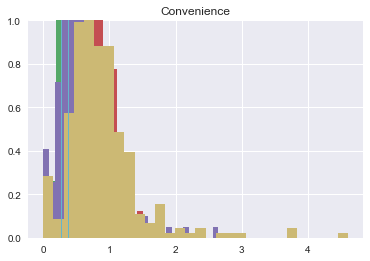

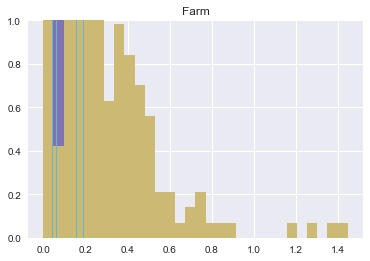

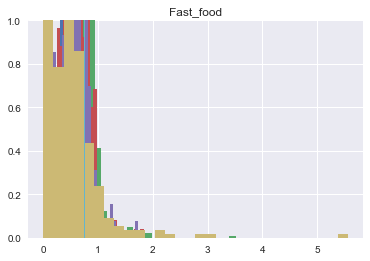

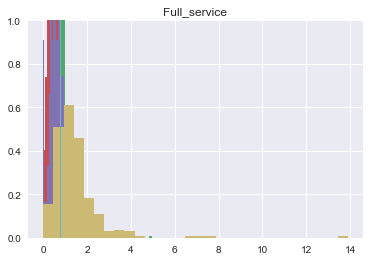

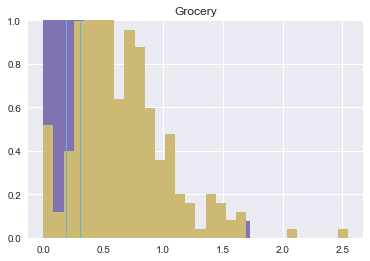

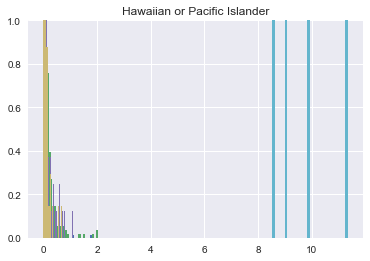

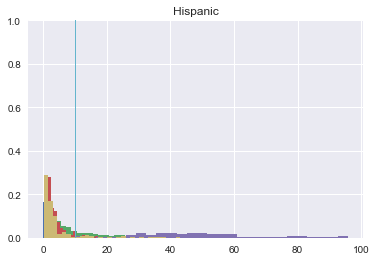

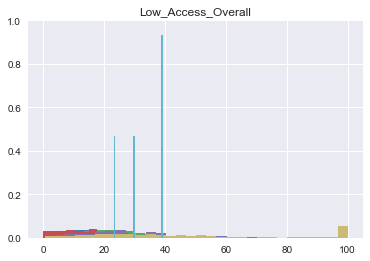

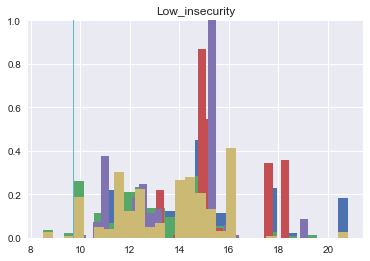

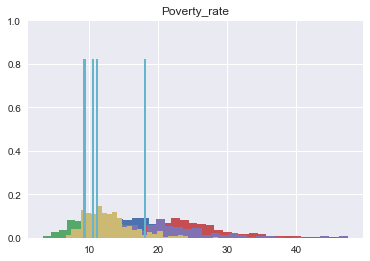

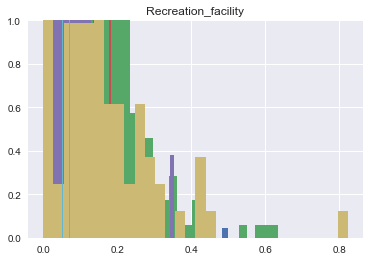

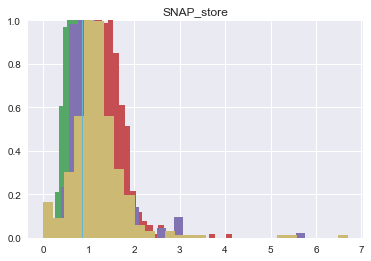

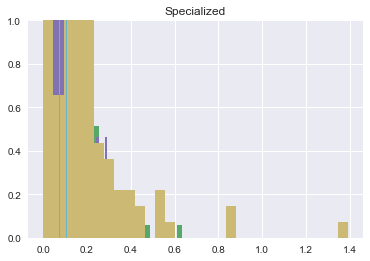

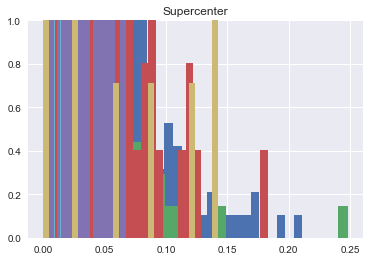

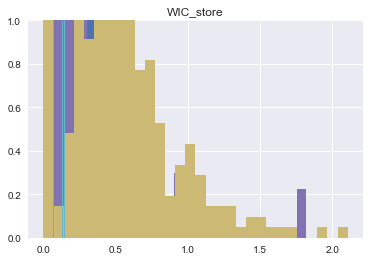

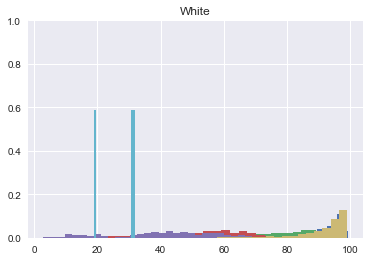

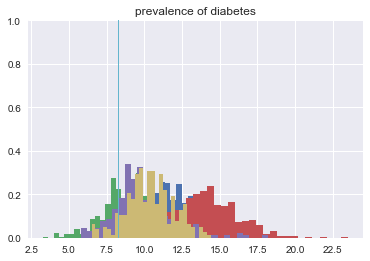

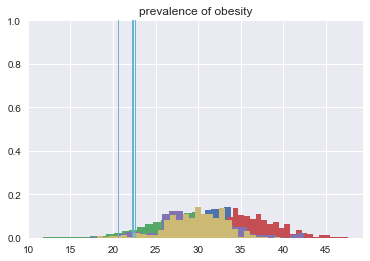

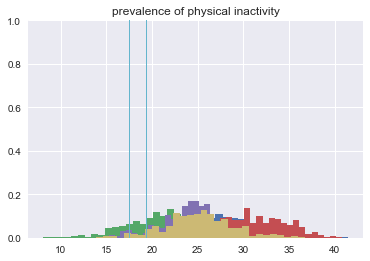

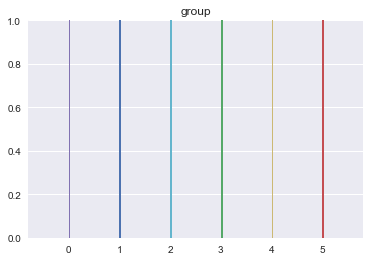

In [35]:
for c in df.columns:
    plt.figure()
    for n in df['group'].unique():
        df[df['group']==n][c].hist(bins=30, normed=True)
    plt.ylim(0,1)
    plt.title(c)
    plt.show()

segmentation based on diabetes prevalence and obesity prevalence

In [36]:
df_levels=pd.DataFrame()
df_levels['level_diabetes']=pd.qcut(df['prevalence of diabetes'], [0, .25, .5, .75, 1.], labels=False)
df_levels['level_obesity']=pd.qcut(df['prevalence of obesity'], [0, .25, .5, .75, 1.], labels=False)
df_levels['level_phy']=pd.qcut(df['prevalence of physical inactivity'], [0, .25, .5, .75, 1.], labels=False)

df_levels.index=df.index

In [40]:
df_subset=df[df_levels['level_diabetes']==3]

kmeans = KMeans(n_clusters=4, random_state=0).fit(df_subset[df_subset.columns.difference(['group'])])
df_subset['group']=kmeans.labels_

C:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [42]:
for c in df_subset.columns:
    plt.figure()
    
    df_subset[c].hist(bins=30, normed=1, by='group')
    #plt.ylim(0,1)
    plt.title(c)
    plt.show()

KeyError: 'group'

In [ ]:
df_subset=df[df_levels['level_diabetes']==3]

kmeans = KMeans(n_clusters=6, random_state=0).fit(df_subset[df_subset.columns.difference(['group'])])
df_subset['group']=kmeans.labels_